# Aim of this document is to create a model of the FWt with Gravity acting as an external force and linerise the EoM about all ifxed points (across velocities)

In [3]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels.dof2 as dof2
import FwtModels.AeroModels as ams

me.mechanics_printing()

### Define the problem

In [25]:
# create instance of a simplified model parameters
# create the variables
p = dof2.FwtParameters.Default2DoF() # parameter container



# set values for independent symbols
p.s.value = 0.3
p.c.value = 0.15
p.g.value = 9.81
p.rho.value = 1.225
p.a_t.value = 2 * np.pi
p.alpha_r.value = np.deg2rad(5)
p.Lambda.value = np.deg2rad(10)

p.m.value = 0.2
p.m_w = dof2.FwtVariable(1,'m_w')   # mass of inner wing

# set expression for dependent symbols
p.k = (sym.Integer(2)*2*sym.pi)**2*(p.m_w+p.m)

p.I_xx = sym.Rational(1,12)*p.m*p.s**2*1
p.l = p.s*sym.Rational(1,2)


p.g.value = 9.81

# potential Energy
half = sym.Rational(1,2)
U = half*p.k*(p.q[1])**2 # + p.m*p.g*(-p.l*sym.sin(p.q[0]))

# Transforms for the mass
wing_frame = symt.HomogenousTransform().Translate(0,0,p.q[1])
fwt_frame = wing_frame.R_x(p.q[0])
fwt_com_frame = fwt_frame.Translate(0,p.l,0)
rot = sym.Matrix([p.q[0],0,0])

mw = dof2.RigidElement.PointMass(wing_frame,sym.Matrix([0,0,0]),p.m_w)
M_fwt = dof2.MassMatrix(p.m,I_xx = p.I_xx)
m = dof2.RigidElement(fwt_com_frame,rot,M_fwt)

# External Forces
AeroForces = ams.AeroModelv1(p,fwt_frame,at_mode=1)
GravityForces = ams.GravityModel(p,fwt_com_frame,sym.Matrix([0,0,p.g*p.m]))
CompositeForce = ams.CompositeForce([GravityForces,AeroForces])

# create instance of the model
sM = dof2.SymbolicModel(U,[mw,m],p,ExtForces = CompositeForce)

### Determine the fixed points of this system

In [19]:
#make alternative dataset
from scipy.optimize import minimize
vs = np.linspace(0,50,201)
aoa = [0,2.5,5,7.5,10]

df = pd.DataFrame(columns=['v','aoa','eta','q1'])

def ToMinimise(x):
    val = sM.deriv(0,[x[0],0,x[1],0],p)
    return val[1]**2 + val[3]**2
    

for i in aoa:
    p.alpha_r.value = np.deg2rad(i)    
    guess = [np.pi/2,0]
    for v in vs:
        p.V.value = v
        guess = minimize(ToMinimise,guess).x
        df = df.append({'aoa' : i, 'v' : v,'eta':guess[0],'q1':guess[1]} , ignore_index=True)

df[r'$\eta [Deg]$']= np.rad2deg(df['eta'])

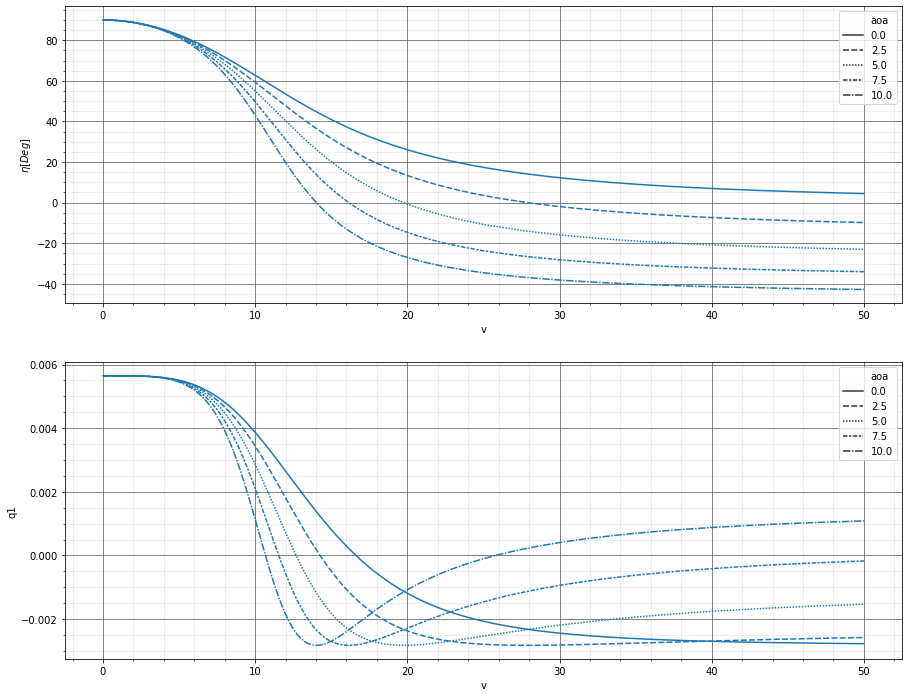

In [20]:
# plot the data
fig, axes = plt.subplots(2,1,figsize=(15,12))
df[r'$\eta [Deg]$']= np.rad2deg(df['eta'])
sns.lineplot(data=df,y=r'$\eta [Deg]$',x='v',style='aoa',ax=axes[0])

sns.lineplot(data=df,y='q1',x='v',style='aoa',ax=axes[1])

for ax in axes:
    #ax.set(xlim=(0,80))
    ax.grid(b=True, which='major', color='#666666', linestyle='-')
    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

### Linearise the system about some fixed points

In [26]:
# create complete EoM
func = dof2.LinearEoM_func(sM,p,ignore=[p.V,p.alpha_r])

In [27]:
dat = df

flutdfv2 = pd.DataFrame()
for a in dat['aoa'].unique():
    #get relevent data points
    data = dat[dat['aoa']==a]
    
    for i in range(0,len(data)):  
        # get the fixed point
        lp = [data['eta'].iloc[i],0,data['q1'].iloc[i],0]
        # get the jacobian evaluated at this point
        j_lp = func(data['v'].iloc[i],np.deg2rad(a),lp)
        # get eigen value information
        jac_dat = dof2.ExtractEigenValueData(j_lp)
        # populate test specific data   
        jac_dat['V'] = data['v'].iloc[i]
        jac_dat['aoa'] = a
        jac_dat['lp'] = [lp for i in range(0,len(jac_dat))]
        flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True)
flutdfv2   

,Mode,cn,Real,Imag,Frequency,Damping,Stable,Eigen Vector,V,aoa,lp
0,0,-0.000000+6.733059j,-1.110223e-16,6.733059,1.071600,6.123234e-17,True,"[(6.91228188056571e-18+0.14690944018150404j), ...",0.00,0.0,"[1.570796326201222, 0, 0.005647497309279125, 0]"
1,1,0.000000+12.566371j,8.881784e-16,12.566371,2.000000,6.123234e-17,True,[(-1.5990672793672715e-25+3.3029197297795763e-...,0.00,0.0,"[1.570796326201222, 0, 0.005647497309279125, 0]"
2,0,-0.027059+6.733041j,-2.705942e-02,6.733041,1.071605,-4.018868e-03,True,[(-0.0005904065164417453-0.14690747839196305j)...,0.25,0.0,"[1.5704705249446553, 0, 0.00564749655589121, 0]"
3,1,-0.000000+12.566371j,-3.417443e-10,12.566371,2.000000,-2.719507e-11,True,[(-5.4140226202685944e-08+0.000181260409996260...,0.25,0.0,"[1.5704705249446553, 0, 0.00564749655589121, 0]"
4,0,-0.054119+6.732989j,-5.411884e-02,6.732989,1.071623,-8.037603e-03,True,"[(-0.0011807744869692112-0.146901546979603j), ...",0.50,0.0,"[1.56949318120418, 0, 0.005647482761141099, 0]"
...,...,...,...,...,...,...,...,...,...,...,...
2005,1,0.383342+13.574108j,3.833424e-01,13.574108,2.161248,2.822945e-02,False,"[(0.0017247313609650649-0.06107252182798807j),...",49.50,10.0,"[-0.7460301541469528, 0, 0.0010785250948348935..."
2006,0,-6.152961+27.000431j,-6.152961e+00,27.000431,4.407420,-2.221876e-01,False,"[(-0.008014356124038939-0.0351686064886183j), ...",49.75,10.0,"[-0.7464673133151108, 0, 0.0010822106910351693..."
2007,1,0.379208+13.572151j,3.792081e-01,13.572151,2.160918,2.792926e-02,False,"[(0.0017008253613551207-0.06087385309687139j),...",49.75,10.0,"[-0.7464673133151108, 0, 0.0010822106910351693..."
2008,0,-6.177597+27.146651j,-6.177597e+00,27.146651,4.430982,-2.218910e-01,False,"[(-0.00796118896192704-0.03498441436733959j), ...",50.00,10.0,"[-0.7468975859384334, 0, 0.0010858386999478451..."


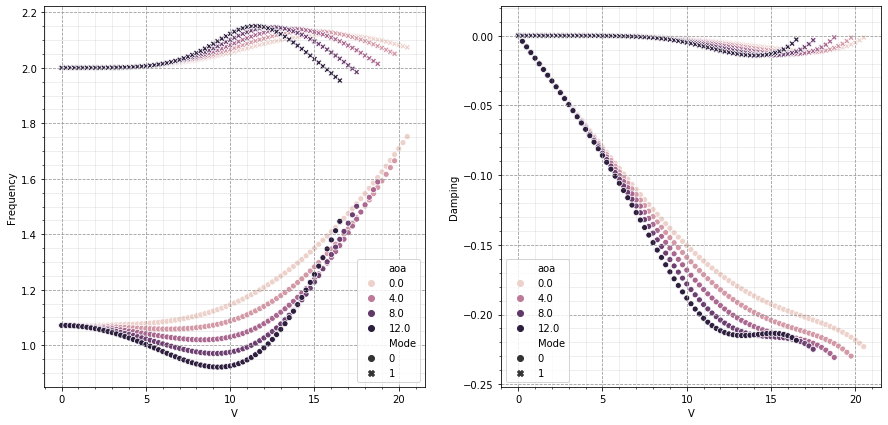

In [28]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
data = flutdfv2[(flutdfv2['Stable'])]
#data = flutdfv2
fig, axes = plt.subplots(1,2,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='aoa',style='Mode',ax=axes[0])
sns.scatterplot(data=data,x='V',y='Damping',hue='aoa',style='Mode',ax=axes[1])
for i in [0,1]:
    #axes[i].set(xlim=(0,80))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

In [11]:
# get info for the first unstable point for each AoA

aoas = data['aoa'].unique()
idx = []

data = flutdfv2[~flutdfv2['Stable']]
for i in data['aoa'].unique():
    idx.append(data[data['aoa']==i].sort_values(by=['V'],axis=0).head(1).index[0])
    
res = flutdfv2.iloc[idx].copy()
res['eta'] = res.apply(lambda row: np.rad2deg(row.lp[0]),axis=1)
res[['aoa','V','eta']]

,aoa,V,eta
298,0.0,37.25,15.748703
692,2.5,36.25,2.677863
1080,5.0,34.50,-9.793504
1468,7.5,32.75,-21.115232
1856,10.0,31.00,-30.653887
